# Stock Prediction Deep Learning Model with Sentiment Analysis

##### I will be testing the LSTM only and then the LSTM with Sentiment Analysis.

In [5]:
# Last updated: 10/18/2023.
# Copyright 2023 Shane Khalid. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================


import math 
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Dropout
from datetime import date, timedelta, datetime
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import utils
# Always use the GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
import os
import csv
import json
import datetime
import pandas as pd
from tqdm import tqdm
import snscrape.modules.twitter as sntwitter
from datetime import datetime

Num GPUs Available:  1


### Loading Dataset

##### This time I will be importing (scraping) from Yahoo Finance. 

In [6]:
# Downloading hostorical stock price data from 1st Jan 2010 to today
stockname = 'GOOG'
interval = '1d' 
date_today = date.today()
date_start = datetime.strptime('2010-01-01', "%Y-%m-%d")

period1 = int(time.mktime(date_start.timetuple()))
period2 = int(time.mktime(date_today.timetuple()))
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{stockname}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

# Saving data to CSV file
stocks_data = pd.read_csv(query_string)
stocks_data.to_csv(stockname + '.csv')

# Loading data into dataframe
df = pd.read_csv(stockname + '.csv',parse_dates = True,index_col=['Date'])
df = df.drop(['Unnamed: 0'],axis=1)

### EDA

In [7]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,15.615220,15.678981,15.547723,15.610239,15.610239,78541293
2010-01-05,15.620949,15.637387,15.480475,15.541497,15.541497,120638494
2010-01-06,15.588072,15.588072,15.102393,15.149715,15.149715,159744526
2010-01-07,15.178109,15.193053,14.760922,14.797037,14.797037,257533695
2010-01-08,14.744733,15.024933,14.672753,14.994298,14.994298,189680313


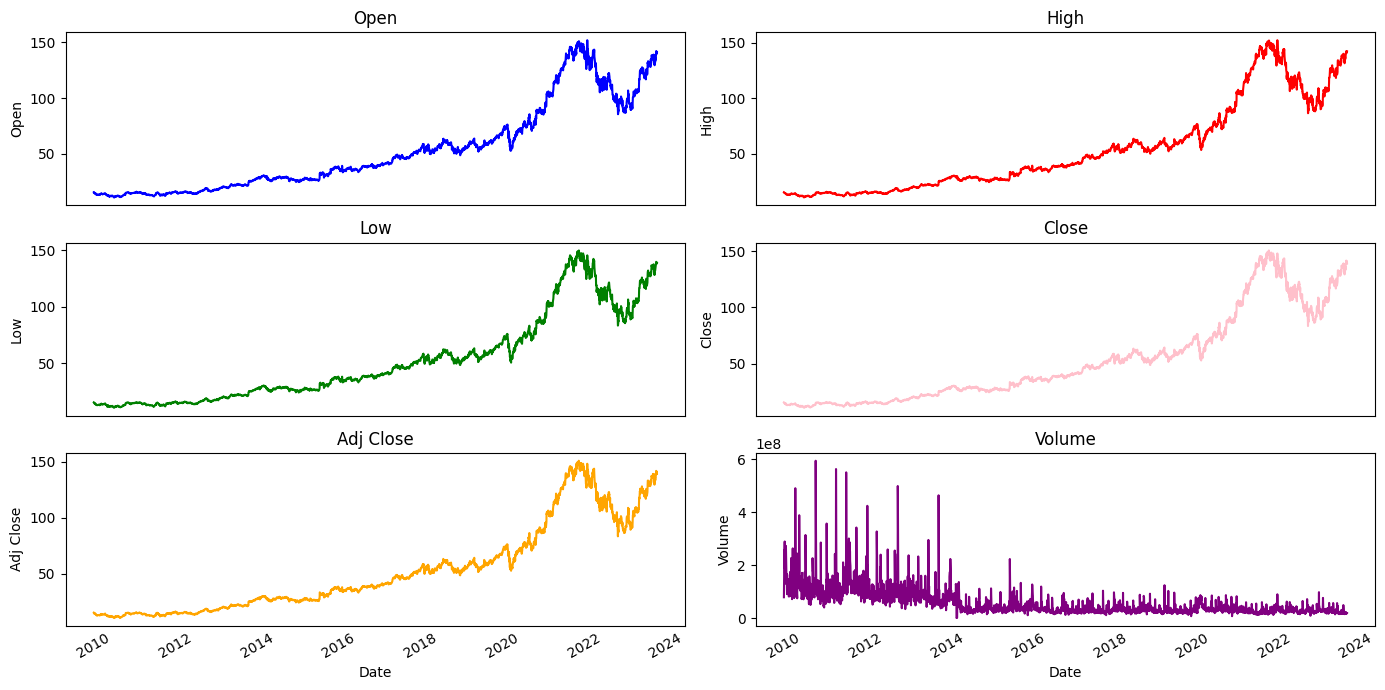

In [8]:
# Plotting line charts
df_plot = df.copy()
list_length = df_plot.shape[1]
ncols = 2
nrows = int(round(list_length / ncols, 0))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
colors = ['blue', 'red', 'green', 'pink', 'orange', 'purple']
for i in range(0, list_length):
        ax = plt.subplot(nrows,ncols,i+1)
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax, color= colors[i])
        ax.set_title(df_plot.columns[i])
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())

fig.tight_layout()
plt.show()

### Preprocessing Data

In [9]:
# Creating n samples, sequence_length time steps per samples
def splitData(sequence_length, data, index_Close):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        #contains sequence_length values 0-sequence_length * columns
        x.append(data[i-sequence_length:i,:]) 
        #contains the prediction values for validation,  for single-step prediction
        y.append(data[i, index_Close]) 
    # Convert the x & y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

def processData(df, FEATURES):
  # Indexing  the batches
  train_df = df.sort_values(by=['Date']).copy()
  # Saving a copy of the dates' index, before we need to reset it to numbers
  date_index = train_df.index
  # Reset the index, so we can convert the date-index to a number-index
  train_df = train_df.reset_index(drop=True).copy()
  # Create the dataset with features and filter the data to the list of FEATURES
  data = pd.DataFrame(train_df)
  data_filtered = data[FEATURES]

  # Adding a prediction column (target variable) and setting dummy values to prepare the data for scaling
  data_filtered_ext = data_filtered.copy()
  data_filtered_ext['Prediction'] = data_filtered_ext['Close']
  # Number of rows in the data
  nrows = data_filtered.shape[0]
  # Convert data to numpy values
  np_data_unscaled = np.array(data_filtered)
  np_data = np.reshape(np_data_unscaled, (nrows, -1))

  # Transform the data by scaling each feature to a range between 0 and 1
  scaler = MinMaxScaler()
  np_data_scaled = scaler.fit_transform(np_data_unscaled)
  # Creating a separate scaler that works on a single column for scaling predictions
  scaler_pred = MinMaxScaler()
  df_Close = pd.DataFrame(data_filtered_ext['Close'])
  np_Close_scaled = scaler_pred.fit_transform(df_Close)

  # sequence length: this is the timeframe used to make a single prediction
  sequence_length = 50
  # Prediction Index
  index_Close = data.columns.get_loc("Close")
  # Split the training data into train and test datasets with 80:20 split 
  train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)
  # Creating the training and test data
  train_data = np_data_scaled[0:train_data_len, :]
  test_data = np_data_scaled[train_data_len - sequence_length:, :]

  # Generate training data and test data
  x_train, y_train = splitData(sequence_length, train_data, index_Close)
  x_test, y_test = splitData(sequence_length, test_data, index_Close)

  return x_train, y_train, x_test, y_test, data_filtered, \
         date_index, scaler, scaler_pred, train_data_len, sequence_length

### Train LSTM model

##### Same as usual. Adam optimizer. 

In [10]:
# Setting up LSTM model architecture

def getModel(x_train):
  # Creating model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
  model = Sequential()
  n_neurons = x_train.shape[1] * x_train.shape[2]
  model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
  model.add(LSTM(n_neurons, return_sequences=False))
  model.add(Dense(5))
  model.add(Dense(1))

  # Compiling the model
  model.compile(optimizer='adam', loss='mse')
  return model

In [11]:
def plotLossCurve(history, color, title):
  # Plot the Loss Curve
  fig, ax = plt.subplots(figsize=(7, 6), sharex=True)
  plt.plot(history.history["loss"],color=color)
  plt.title(title)
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.xticks(rotation=45)
  plt.legend(["Train", "Test"], loc="upper left")
  plt.show()

### Evaluate Model Performance

In [12]:
def eval(model, x_test, y_test, scaler_pred):
  # Get the predicted values
  y_pred_scaled = model.predict(x_test)
  # Unscale the predicted values
  y_pred = scaler_pred.inverse_transform(y_pred_scaled)
  y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

  # Mean Absolute Error (MAE)
  MAE = mean_absolute_error(y_test_unscaled, y_pred)
  print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
  print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

  # Median Absolute Percentage Error (MDAPE)
  MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
  print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

  return MAE, MAPE, MDAPE, y_pred

### Visualize

In [13]:
def visualizePreds(data_filtered, train_data_len, y_pred, date_index, color):
  # The date from which on the date is displayed
  display_start_date = pd.Timestamp('today') - timedelta(days=500)
  # Add the date column
  data_filtered_sub = data_filtered.copy()
  data_filtered_sub['Date'] = date_index

  # Add the difference between the valid and predicted prices
  train = data_filtered_sub[:train_data_len + 1]
  valid = data_filtered_sub[train_data_len:]
  
  valid.insert(1, "Prediction", y_pred.ravel(), True)
  valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
  # Zoom in to a closer timeframe
  valid = valid[valid['Date'] > display_start_date]
  train = train[train['Date'] > display_start_date]
  
  # Visualize the data
  fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
  xt = train['Date']; yt = train[["Close"]]
  xv = valid['Date']; yv = valid[["Close", "Prediction"]]
  plt.title("Predictions vs Actual Values", fontsize=20)
  plt.ylabel(stockname, fontsize=18)
  plt.plot(xt, yt, color="green", linewidth=2.0)
  plt.plot(xv, yv["Prediction"], color=color, linewidth=2.0)
  plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
  plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")
  plt.show()

### Predict tomorrow's price

In [14]:
def predictFuturePrice(model, df, sequence_length, feats, scaler, scaler_pred):
  df_temp = df[-sequence_length:]
  new_df = df_temp.filter(feats)
  N = sequence_length
  # Get the last N day closing price values and scale the data to be values between 0 and 1
  last_N_days = new_df[-sequence_length:].values
  last_N_days_scaled = scaler.transform(last_N_days)

  # Create an empty list and Append past N days
  X_test_new = []
  X_test_new.append(last_N_days_scaled)
  # Convert the X_test data set to a numpy array and reshape the data
  pred_price_scaled = model.predict(np.array(X_test_new))
  pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))
  # Print last price and predicted price for the next day
  price_today = np.round(new_df['Close'][-1], 2)
  predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
  change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

  plus = '+'; minus = ''
  print(f'The close price for {stockname} at {date_today} was {price_today}')
  print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

### LSTM without Sentiment Analysis

In [15]:
# List of considered features
features1 = ['High', 'Low', 'Open', 'Close', 'Volume']  
# Split and process dataset
x_train1, y_train1, x_test1, y_test1, data_filtered1, date_index1, \
scaler1, scaler_pred1, train_data_len1, sequence_length1 = processData(df, features1)
# Get Model
model1 = getModel(x_train1)
#Visualizing Model Architecture
import tensorflow as tf
tf.keras.utils.plot_model(model1, show_shapes=True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

!pip3 install pydot
!pip3 install graphviz

2023-10-19 17:27:27.723503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:43:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-19 17:27:27.723609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:43:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-19 17:27:27.723648: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:43:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-19 17:27:28.951549: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:43:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-19 17:27:28.951619: I tensorflow/compile

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Num GPUs Available:  1
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [16]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 250)           256000    
                                                                 
 lstm_1 (LSTM)               (None, 250)               501000    
                                                                 
 dense (Dense)               (None, 5)                 1255      
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 758261 (2.89 MB)
Trainable params: 758261 (2.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
# Training the model
epochs = 300
history1 = model1.fit(x_train1, y_train1, batch_size=512, epochs=epochs, validation_data=(x_test1, y_test1))

Epoch 1/300
6/6 [==============================] - 0s 36ms/step - loss: 5.1939e-05 - val_loss: 5.8007e-04
Epoch 2/300
6/6 [==============================] - 0s 29ms/step - loss: 5.1459e-05 - val_loss: 6.0817e-04
Epoch 3/300
6/6 [==============================] - 0s 29ms/step - loss: 5.6616e-05 - val_loss: 5.9028e-04
Epoch 4/300
6/6 [==============================] - 0s 29ms/step - loss: 5.9010e-05 - val_loss: 8.4292e-04
Epoch 5/300
6/6 [==============================] - 0s 29ms/step - loss: 6.1818e-05 - val_loss: 5.7464e-04
Epoch 6/300
6/6 [==============================] - 0s 29ms/step - loss: 5.3029e-05 - val_loss: 5.6822e-04
Epoch 7/300
6/6 [==============================] - 0s 29ms/step - loss: 5.1655e-05 - val_loss: 5.7920e-04
Epoch 8/300
6/6 [==============================] - 0s 29ms/step - loss: 5.0274e-05 - val_loss: 5.6693e-04
Epoch 9/300
6/6 [==============================] - 0s 28ms/step - loss: 5.1249e-05 - val_loss: 5.5994e-04
Epoch 10/300
6/6 [============================

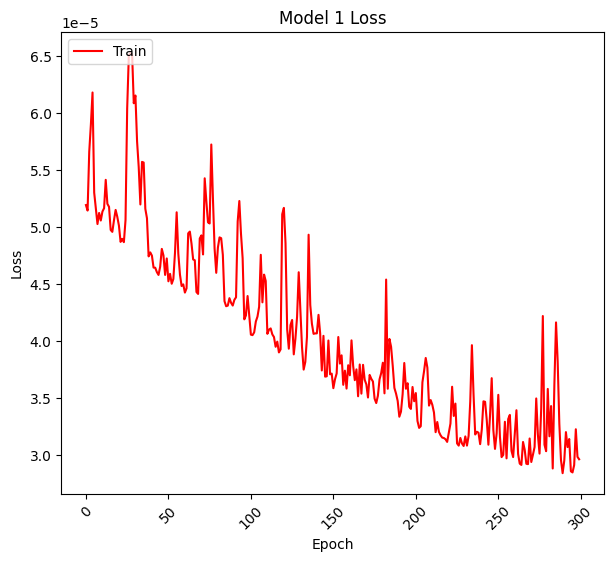

In [34]:
# Plotting Loss Curve
plotLossCurve(history1,"red", "Model 1 Loss")     

#### Hmm.. My loss is still pretty high. Maybe I'll try it with more epochs later

In [35]:
# Evaluating model
MAE1, MAPE1, MDAPE1, y_pred1= eval(model1, x_test1, y_test1, scaler_pred1)

22/22 [==============================] - 1s 18ms/step
Median Absolute Error (MAE): 1.79
Mean Absolute Percentage Error (MAPE): 1.55 %
Median Absolute Percentage Error (MDAPE): 1.12 %


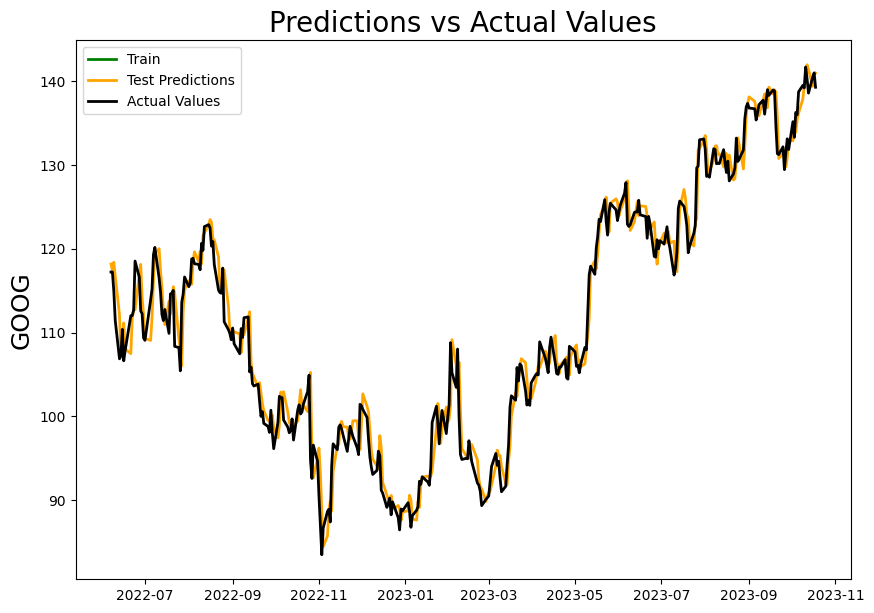

In [36]:
# Visualising Predictions
visualizePreds(data_filtered1, train_data_len1, y_pred1, date_index1, "orange")

#### Where is my Train data? Fix this later.

### Predict tomorrow's price

In [37]:
predictFuturePrice(model1, df, sequence_length1, features1, scaler1, scaler_pred1)

1/1 [==============================] - 0s 28ms/step
The close price for GOOG at 2023-10-19 was 139.28
The predicted close price is 140.5500030517578 (+0.9%)


/tmp/ipykernel_15950/3096130203.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price_today = np.round(new_df['Close'][-1], 2)


### Accurate prediction within 0.9%!
### Now let's add Sentiment Analysis

## BERT Sentiment Analysis

##### Going to use tweet data

In [ ]:
import os
import csv
import json
import datetime
import pandas as pd
from tqdm import tqdm
import snscrape.modules.twitter as sntwitter

path = "./GOOG_tweets.json"

if os.path.isfile(stockname + '_tweets.json'):
  print("File already exits...no need to scrape it again")
  print("To scrape again, delete : " + stockname + '_tweets.json')
else:
  maxTweets = 3
  start_date = date_start.date()
  period = (date_today - start_date).days

  tweets = dict()
  for i in tqdm(range(period)):
    dayTweets=list()
    start_interval = start_date
    end_interval = start_interval + datetime.timedelta(days=1)
    try: 
      for i,tweet in enumerate(sntwitter.TwitterSearchScraper('#Apple + OR @Apple + since:' + str(start_interval) + ' until:' + str(end_interval) +' -filter:links -filter:replies  lang:"en" ').get_items()):
          if i > maxTweets :
            break  
          dayTweets.append(tweet.content)
      key = start_date.strftime('%d/%m/%Y')
      tweets[key] = dayTweets
      start_date += datetime.timedelta(days=1)  
    except Exception as e:
      print(i,e)
      pass

  with open( stockname + '_tweets.json', 'w') as fp:
      json.dump(tweets, fp)

In [6]:
df_senti = pd.read_csv('GOOG_senti_scores.csv')
df_senti.set_index('Date', inplace=True)
df2 = df.join(df_senti, how='inner')
df2.head()

,Open,High,Low,Close,Adj Close,Volume,Unnamed: 0,NEG,NEU,POS
Date,,,,,,,,,,


In [ ]:
import json
f = open(stockname + '_tweets.json',)
data = json.load(f)

dates = list()
NEG = list()
NEU = list()
POS = list()

for key in tqdm(data):
  reviews = data[key]
  pos=0
  neg=0
  neu=0
  cnt=0
  for text in reviews:
    cnt=cnt+1
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    neg=neg+scores[0]
    neu=neu+scores[1]
    pos=pos+scores[2]

  NEG.append(neg/cnt)
  NEU.append(neu/cnt)
  POS.append(pos/cnt)
  dates.append(datetime.strptime(str(key), "%d/%m/%Y"))

In [ ]:

import csv
import json
import datetime
import pandas as pd
from tqdm import tqdm
import snscrape.modules.twitter as sntwitter

if os.path.isfile(stockname + '_tweets.json'):
  print("File already exists...no need to scrape it again")
  print("To scrape again, delete : " + stockname + '_tweets.json')
else:
  maxTweets = 3
  start_date = date_start.date()
  period = (date_today - start_date).days

  tweets = dict()
  for i in tqdm(range(period)):
    dayTweets=list()
    start_interval = start_date
    end_interval = start_interval + datetime.timedelta(days=1)
    try: 
      for i,tweet in enumerate(sntwitter.TwitterSearchScraper('#Google + OR @Google + since:' + str(start_interval) + ' until:' + str(end_interval) +' -filter:links -filter:replies  lang:"en" ').get_items()):
          if i > maxTweets :
            break  
          dayTweets.append(tweet.content)
      key = start_date.strftime('%d/%m/%Y')
      tweets[key] = dayTweets
      start_date += datetime.timedelta(days=1)  
    except Exception as e:
      print(i,e)
      pass

  with open( stockname + '_tweets.json', 'w') as fp:
      json.dump(tweets, fp)

In [40]:
import os, csv
import urllib.request
from scipy.special import softmax
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer